In [17]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.color_palette('Paired')

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
def load_data(azdias_path, customers_path, attribute_value_path, attribute_info_path):
    '''
    Load azdias, customer, attribute value and attribute information data
    
    INPUT:
          azdias_path: azdias data path
          customers_path: customers data path
          attribute_value_path: attribute value data path
          attribute_info_path: attribute information data path
    
    OUTPUT:
        azdias: azdias DataFrame
        customers: customers DataFrame
        attributes_values: attribute values DataFrame
        attributes_info: attribute information DataFrame
    '''
    
    
    # azdias_path = './data/Udacity_AZDIAS_052018.csv'
    # customers_path = './data/Udacity_CUSTOMERS_052018.csv'
    # attribute_value_path = './DIAS/DIAS Attributes - Values 2017.xlsx'
    # attribute_info_path = './DIAS/DIAS Information Levels - Attributes 2017.xlsx'

    print('.......... Loading Azdias and Customers Data ..........')
    azdias = pd.read_csv(azdias_path, sep=';', low_memory=False)
    customers = pd.read_csv(customers_path, sep=';', low_memory=False)

    print('There are {} rows and {} columns in azdias dataset;'.format(azdias.shape[0], azdias.shape[1]))
    print('There are {} rows and {} columns in customers dataset.'.format(customers.shape[0], customers.shape[1]))
    

    print('.......... Loading Attributes Values and Information Data ..........')
    attributes_values = pd.read_excel(attribute_value_path, header=1)
    attributes_info = pd.read_excel(attribute_info_path, header=1)

    del attributes_values['Unnamed: 0']
    del attributes_info['Unnamed: 0']
     
    attributes_values['Attribute'].ffill(inplace=True)
    
    print('There are {} unique attributes in DIAS Attributes file.'.format(attributes_values.Attribute.nunique()))
    print('The number of attributes in azdias file is {}.'.format(azdias.shape[1]))
    print('The number of attributes in customers file is {}.'.format(customers.shape[1]))
    
    
    return azdias, customers, attributes_values, attributes_info


In [3]:
   
azdias_path = './data/Udacity_AZDIAS_052018.csv'
customers_path = './data/Udacity_CUSTOMERS_052018.csv'
attribute_value_path = './DIAS/DIAS Attributes - Values 2017.xlsx'
attribute_info_path = './DIAS/DIAS Information Levels - Attributes 2017.xlsx'

azdias, customers, attributes_values, attributes_info = load_data(azdias_path, customers_path, attribute_value_path, attribute_info_path)

......Loading Azdias and Customers Data......
There are 891221 rows and 366 columns in azdias dataset;
There are 191652 rows and 369 columns in customers dataset.
......Loading Attributes Values and Information Data......
There are 314 unique attributes in DIAS Attributes file.
The number of attributes in azdias file is 366.
The number of attributes in customers file is 369.


In [10]:
def clean_values(values_dict):
    '''
    For possible and unknown value dictionaries, 
    remove the "'" characters in the value lists
    
    INPUT:
          values_dict: dictionary with values containing "'"
    
    OUTPUT:
          updated_dict: updated dictionary without "'"   
    '''

    for attr, val in values_dict.items():
      if '-1, 9' in values_dict[attr]:
            values_dict[attr].remove('-1, 9')
            if -1 not in values_dict[attr]:
                  values_dict[attr].insert(0, -1)
            if 9 not in values_dict[attr]:
                  values_dict[attr].insert(1, 9)

    for attr, val in values_dict.items():
      if '-1, 0' in values_dict[attr]:
            values_dict[attr].remove('-1, 0')
            if -1 not in values_dict[attr]:
                  values_dict[attr].insert(0, -1)
            if 9 not in values_dict[attr]:
                  values_dict[attr].insert(1, 0)
    
    for attr, val in values_dict.items():
      if '-1' in values_dict[attr]:
        values_dict[attr].remove('-1')
        if -1 not in values_dict[attr]:
            values_dict[attr].insert(0, -1)
      
    updated_dict = values_dict

    return updated_dict


In [12]:
def process_attributes(azdias, customers, attributes_values):
    '''
     Assess attributes in azdias and customers dataset, record data types, possible values 
     and unknown values for each attribute.
    
    INPUT:
         azdias: azdias DataFrame
         customers: customers DataFrame
         attributes_values: attribute values DataFrame

    
    OUTPUT:
          df_dtypes: DataFrame with data types of azdias and customers columns
          possible_values: Dictionary with possible values for each attribute
          unknown_values: Dictionary with unknown values for each attribute

        
    '''
    print('............. Assess Attributes ..........')
    # attributes in both DIAS Attributes file and azdias
    azdias_comm_attr = set(attributes_values['Attribute'].unique()).intersection(set(azdias.columns))
    # attributes in both DIAS Attributes file and costomers
    customers_comm_attr = set(attributes_values['Attribute'].unique()).intersection(set(customers.columns))
    # attributes in both azdias and costomers
    azdias_cust_comm = set(azdias.columns).intersection(set(customers.columns))

    print('The number of attributes both in DIAS file and azdias is {}.'.format(len(azdias_comm_attr)))
    print('The number of attributes both in DIAS file and customers is {}.'.format(len(customers_comm_attr)))
    print('The number of atttributes both in azdias and customers is {}.'.format(len(azdias_cust_comm))) 

    # columns only in customers
    print('Atttributes only customers file but not azdias are {}.'.format(set(customers.columns)-azdias_cust_comm)) 


    print('.......... Process Data Types ..........')
    # record data types
    df_dtypes = azdias.dtypes.to_frame().merge(customers.dtypes.to_frame(), how='inner', left_index=True, \
    right_index=True, suffixes=('_azdias', '_customers'))

    df_dtypes.columns = ['dtype_azdias', 'dtype_customers']
    df_dtypes['if_same'] = (df_dtypes['dtype_azdias'] ==df_dtypes['dtype_customers'])

    df_dtypes.dtype_azdias.value_counts()

    print('There are {} mismatched data types for attributes in azdias and customers datasets'.format(len(azdias_cust_comm)-sum(df_dtypes['if_same'])))

    print('.......... Process Possible Values in Attributes ..........')
    # record possible values
    possible_values = {}

    for attr in azdias_comm_attr:
      possible_values[attr] = list(attributes_values[attributes_values['Attribute']==attr]['Value'].values)

    # attributes have only one possible value
    print('..... Checking Invalid Values .....')
    invalid_attr = []
    for key in possible_values.keys():
      if len(possible_values[key]) <= 1:
            print(key, possible_values[key])
            invalid_attr.append(key)
  
    # for attributes that is any numeric values, use 10000 instead
    possible_values.update({'ANZ_HAUSHALTE_AKTIV':[1,2,3,4,5,6,7,8,9,10],
    'ANZ_HH_TITEL':[1,2,3,4,5,6,7,8,9,10],
    'ANZ_PERSONEN':[1,2,3], 
    'ANZ_TITEL':[1,2,3,4,5,6,7,8,9,10],
    'GEBURTSJAHR':[10000],
    'KBA13_ANZAHL_PKW':[10000],
    'MIN_GEBAEUDEJAHR':[10000]})

    possible_values_updated = clean_values(possible_values)

    print('..... The First Five Attributes in Updated Possible Values Dictionary:')
    print(list(possible_values_updated.items())[:5])
    
    print('.......... Process Unknown Values in Attributes ..........')
    # record unknown values
    unknown_values = {}
    # unknown_words = ['unknown', 'unknown / no main age detectable',
    # 'no transactions known', 'no transaction known']
    unknown_words = ['unknown', 'unknown / no main age detectable']

    for attr in azdias_comm_attr:
      unknown_values[attr] = list(attributes_values[(attributes_values['Attribute']==attr) & \
       (attributes_values['Meaning'].isin(unknown_words))]['Value'].values)
      
    unknown_values_updated = clean_values(unknown_values)

    print('..... The First Five Attributes in Updated Unknown Values Dictionary:')
    print(list(unknown_values_updated.items())[:5])

    print('.......... Attributes Processing Completed ..........')
    possible_values = possible_values_updated
    unknown_values = unknown_values_updated

    return df_dtypes, possible_values, unknown_values



In [13]:
df_dtypes, possible_values, unknown_values = process_attributes(azdias, customers, attributes_values)

............. Assess Attributes ..........
The number of attributes both in DIAS file and azdias is 272.
The number of attributes both in DIAS file and customers is 272.
The number of atttributes both in azdias and customers is 366.
Atttributes only customers file but not azdias are {'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'}.
............. Process Data Types ..........
There are 0 mismatched data types for attributes in azdias and customers datasets
.......... Process Possible Values in Attributes ..........
..... Checking Invalid Values .....
ANZ_HAUSHALTE_AKTIV ['…']
ANZ_PERSONEN ['…']
MIN_GEBAEUDEJAHR ['…']
KBA13_ANZAHL_PKW ['…']
GEBURTSJAHR ['…']
ANZ_TITEL ['…']
ANZ_HH_TITEL ['…']
..... The First Five Attributes in Updated Possible Values Dictionary:
[('RETOURTYP_BK_S', [0, 1, 2, 3, 4, 5]), ('ONLINE_AFFINITAET', [0, 1, 2, 3, 4, 5]), ('KBA13_SEG_VAN', [-1, 0, 1, 2, 3, 4, 5]), ('SEMIO_VERT', [-1, 9, 1, 2, 3, 4, 5, 6, 7]), ('KBA13_SITZE_5', [-1, 0, 1, 2, 3, 4, 5])]
.......

In [30]:
def clean_dtypes(azdias, customers, df_dtypes):
    '''
    Clean data types in azdias and customers dataset
    
    INPUT:
         azdias: azdias DataFrame
         customers: customers DataFrame
         df_dtypes: DataFrame with data types of azdias and customers columns
    
    OUTPUT:
         azdias: azdias DataFrame with cleaned data types
         customers: customers DataFrame with cleaned data types
         df_dtypes: data taypes DataFrame with updated data types
    
    '''
    print('.......... Assess Data Types ..........')
    print('{}'.format(df_dtypes.value_counts()))
    
    print('.......... Cleaning Object Data ..........')
    # clean CAMEO_DEUG_2015
    df_dtypes.loc['CAMEO_DEUG_2015', 'dtype_azdias'] = 'float64'
    df_dtypes.loc['CAMEO_DEUG_2015', 'dtype_customers'] = 'float64'
    
    azdias['CAMEO_DEUG_2015'].loc[azdias['CAMEO_DEUG_2015'] == 'X'] = np.nan
    azdias.CAMEO_DEUG_2015 = azdias.CAMEO_DEUG_2015.astype('float64')
    
    customers['CAMEO_DEUG_2015'].loc[customers['CAMEO_DEUG_2015'] == 'X'] = np.nan
    customers.CAMEO_DEUG_2015 = customers.CAMEO_DEUG_2015.astype('float64')
    
    # clean CAMEO_INTL_2015
    df_dtypes.loc['CAMEO_INTL_2015', 'dtype_azdias'] = 'float64'
    df_dtypes.loc['CAMEO_INTL_2015', 'dtype_customers'] = 'float64'

    azdias['CAMEO_INTL_2015'].loc[azdias['CAMEO_INTL_2015'] == 'XX'] = np.nan
    azdias.CAMEO_INTL_2015 = azdias.CAMEO_INTL_2015.astype('float64')
    
    customers['CAMEO_INTL_2015'].loc[customers['CAMEO_INTL_2015'] == 'XX'] = np.nan
    customers.CAMEO_INTL_2015 = customers.CAMEO_INTL_2015.astype('float64')

    # clean EINGEFUEGT_AM
    df_dtypes.loc['EINGEFUEGT_AM', 'dtype_azdias'] = 'datetime64[s]'
    df_dtypes.loc['EINGEFUEGT_AM', 'dtype_customers'] = 'datetime64[s]'
    
    azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'], format='%Y-%m-%d')
    azdias['EINGEFUEGT_AM'] = azdias['EINGEFUEGT_AM'].astype('datetime64[s]')
    
    customers['EINGEFUEGT_AM'] = pd.to_datetime(customers['EINGEFUEGT_AM'], format='%Y-%m-%d')
    customers['EINGEFUEGT_AM'] = customers['EINGEFUEGT_AM'].astype('datetime64[s]')

    print('.......... Finish Cleaning Object Data ..........')

    time.sleep(5)
    print('.......... Plot Histogram of Numerical Data ..........')
    print('..... Plot 1- Azdias-Int; Plot 2- Customers-Int; Plot 3- Azdias-FLoat; Plot 4&5- Customers-Float:')
    azdias[df_dtypes[df_dtypes.dtype_azdias=='int64'].index].hist(figsize=(50, 50))
    customers[df_dtypes[df_dtypes.dtype_azdias=='int64'].index].hist(figsize=(50, 50))
    
    azdias[df_dtypes[df_dtypes.dtype_azdias=='float64'].index[0:100]].hist(figsize=(50, 50))
  
    customers[df_dtypes[df_dtypes.dtype_azdias=='float64'].index[100:200]].hist(figsize=(50, 50))
    customers[df_dtypes[df_dtypes.dtype_azdias=='float64'].index[200:300]].hist(figsize=(50, 50))

    
    print('.......... Updated Data Types ..........')
    print('{}'.format(df_dtypes.value_counts()))
    
    print('.......... Data Type Cleaning Completed ..........')

    return azdias, customers, df_dtypes



.......... Assess Data Types ..........
dtype_azdias   dtype_customers  if_same
float64        float64          True       267
int64          int64            True        93
object         object           True         3
float64        float64          True         2
datetime64[s]  datetime64[s]    True         1
dtype: int64
.......... Cleaning Object Data ..........
.......... Finish Cleaning Object Data ..........


/Users/nanliwang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


.......... Plot Histogram of Numerical Data ..........
..... Plot 1- Azdias-Int; Plot 2- Customers-Int; Plot 3- Azdias-FLoat; Plot 4&5- Customers-Float:
.......... Updated Data Types ..........
dtype_azdias   dtype_customers  if_same
float64        float64          True       267
int64          int64            True        93
object         object           True         3
float64        float64          True         2
datetime64[s]  datetime64[s]    True         1
dtype: int64
.......... Data Type Cleaning Completed ..........


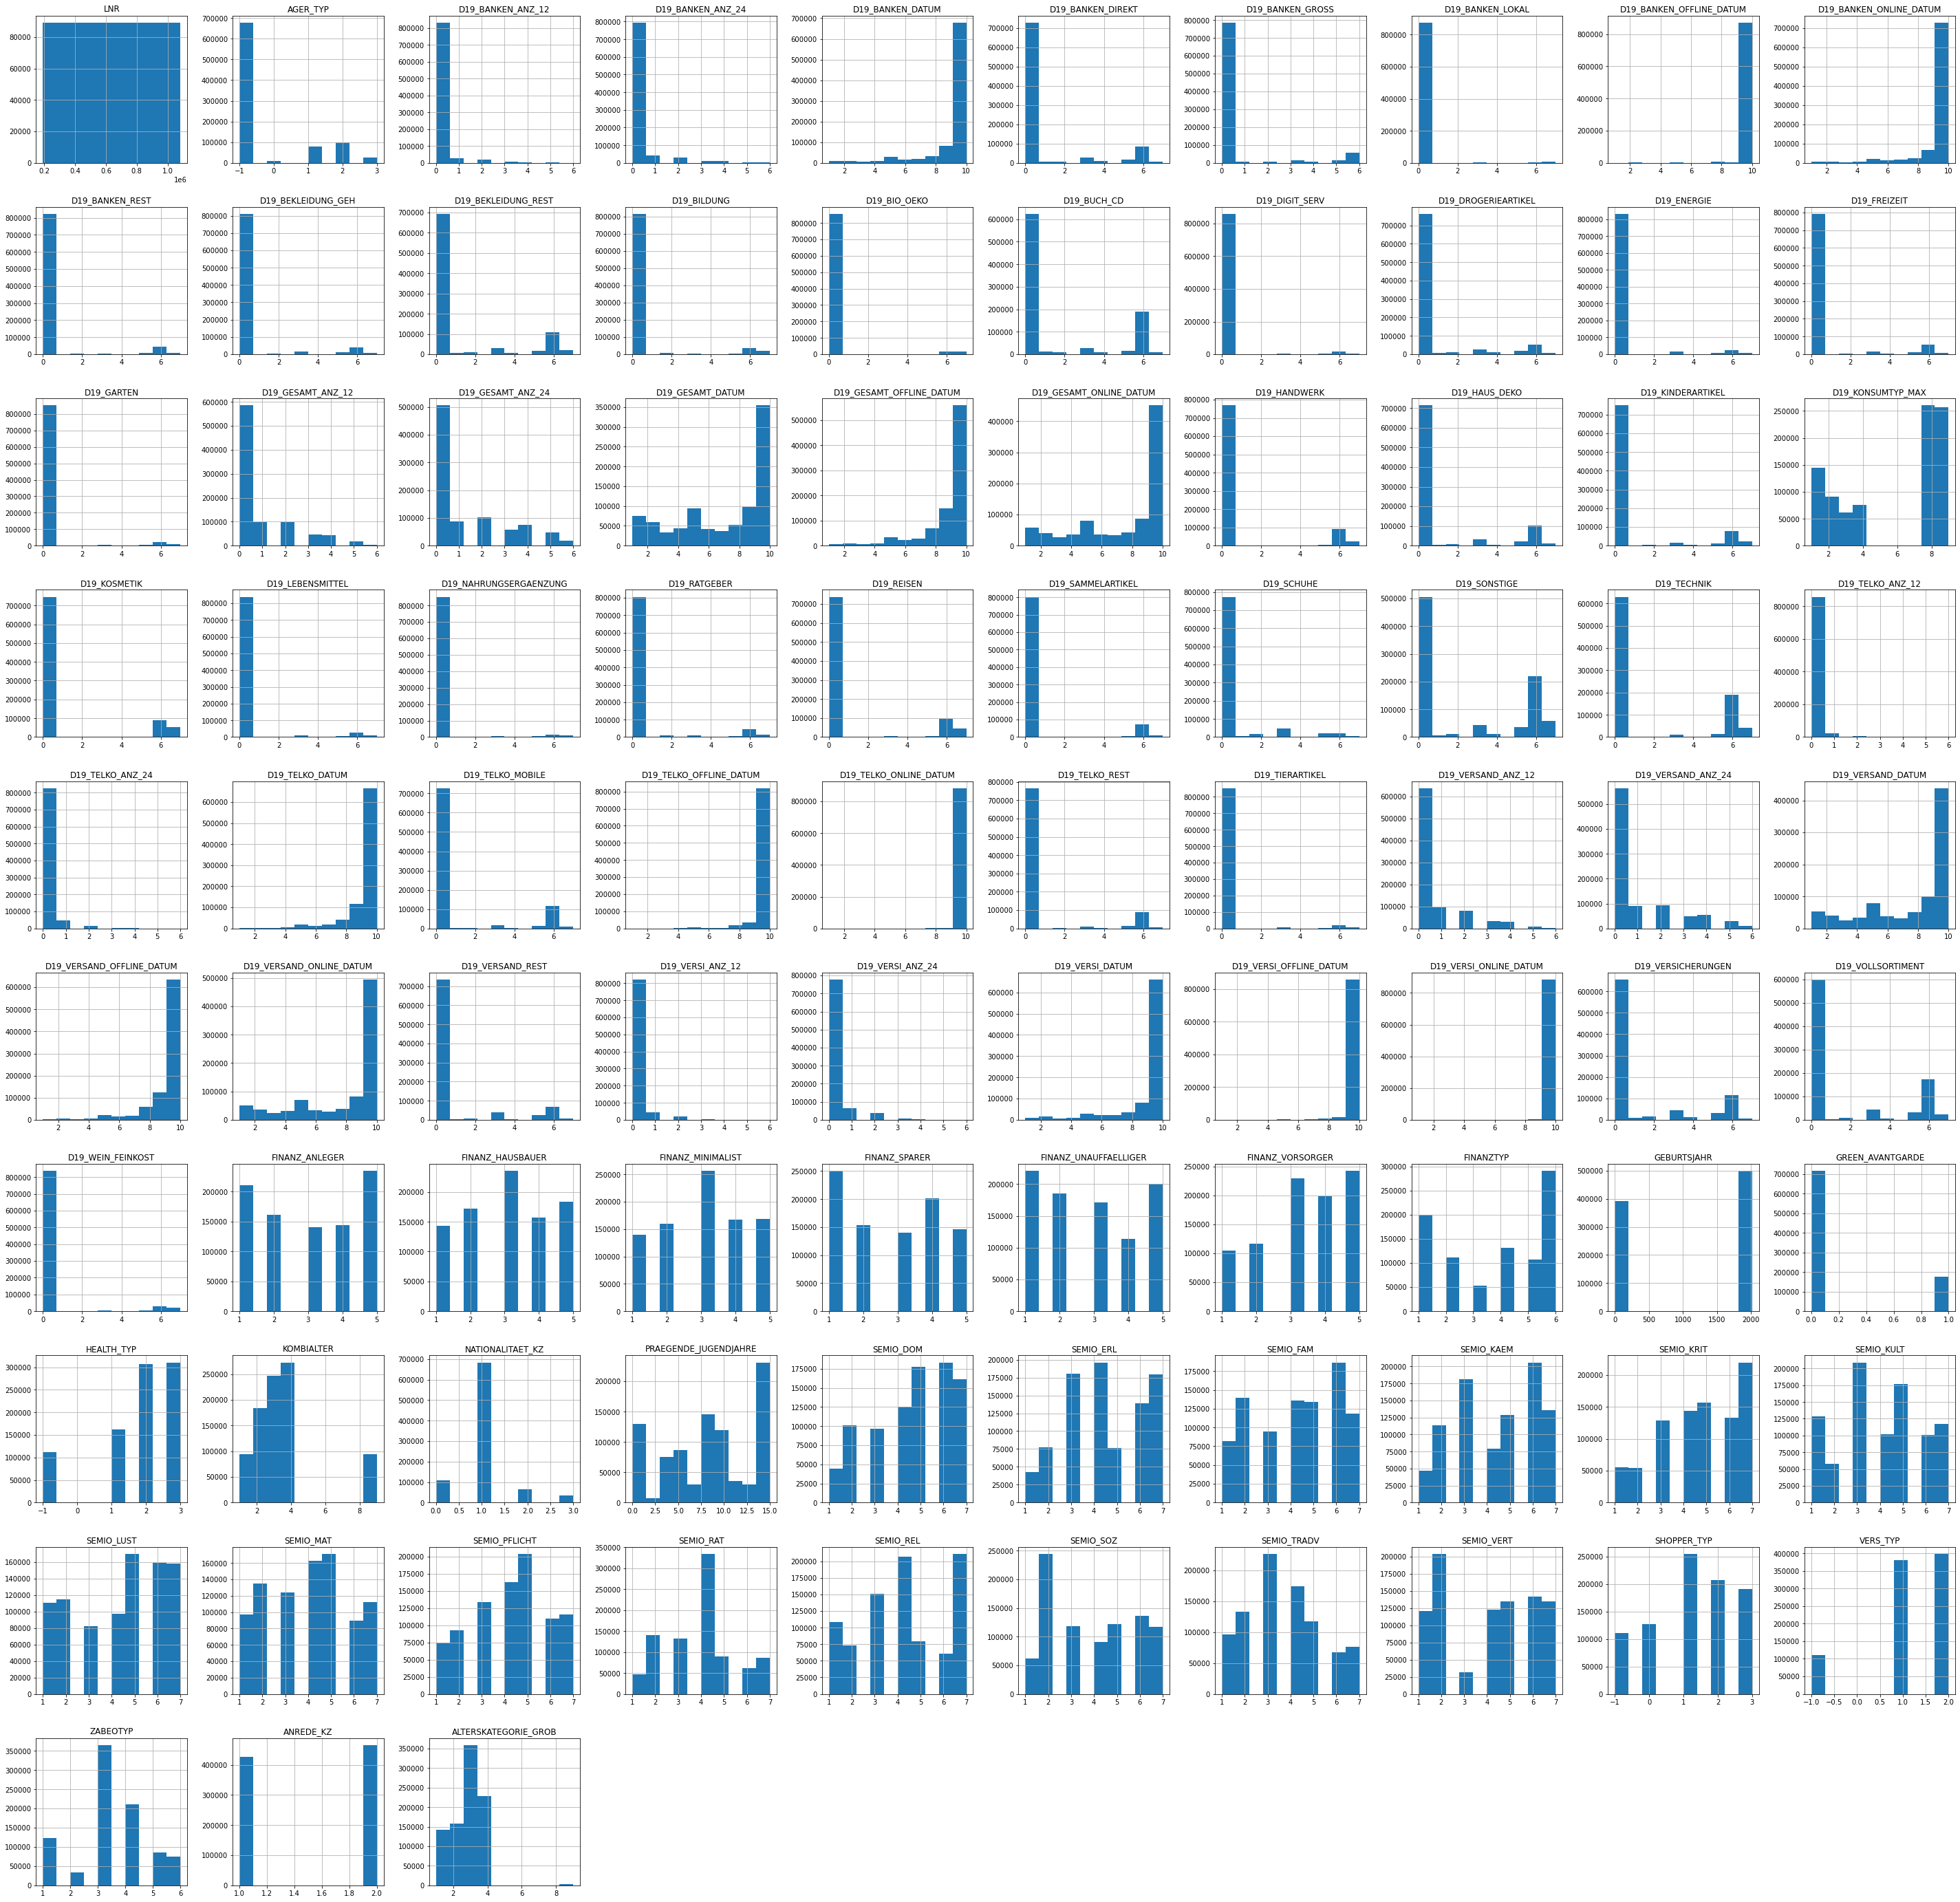

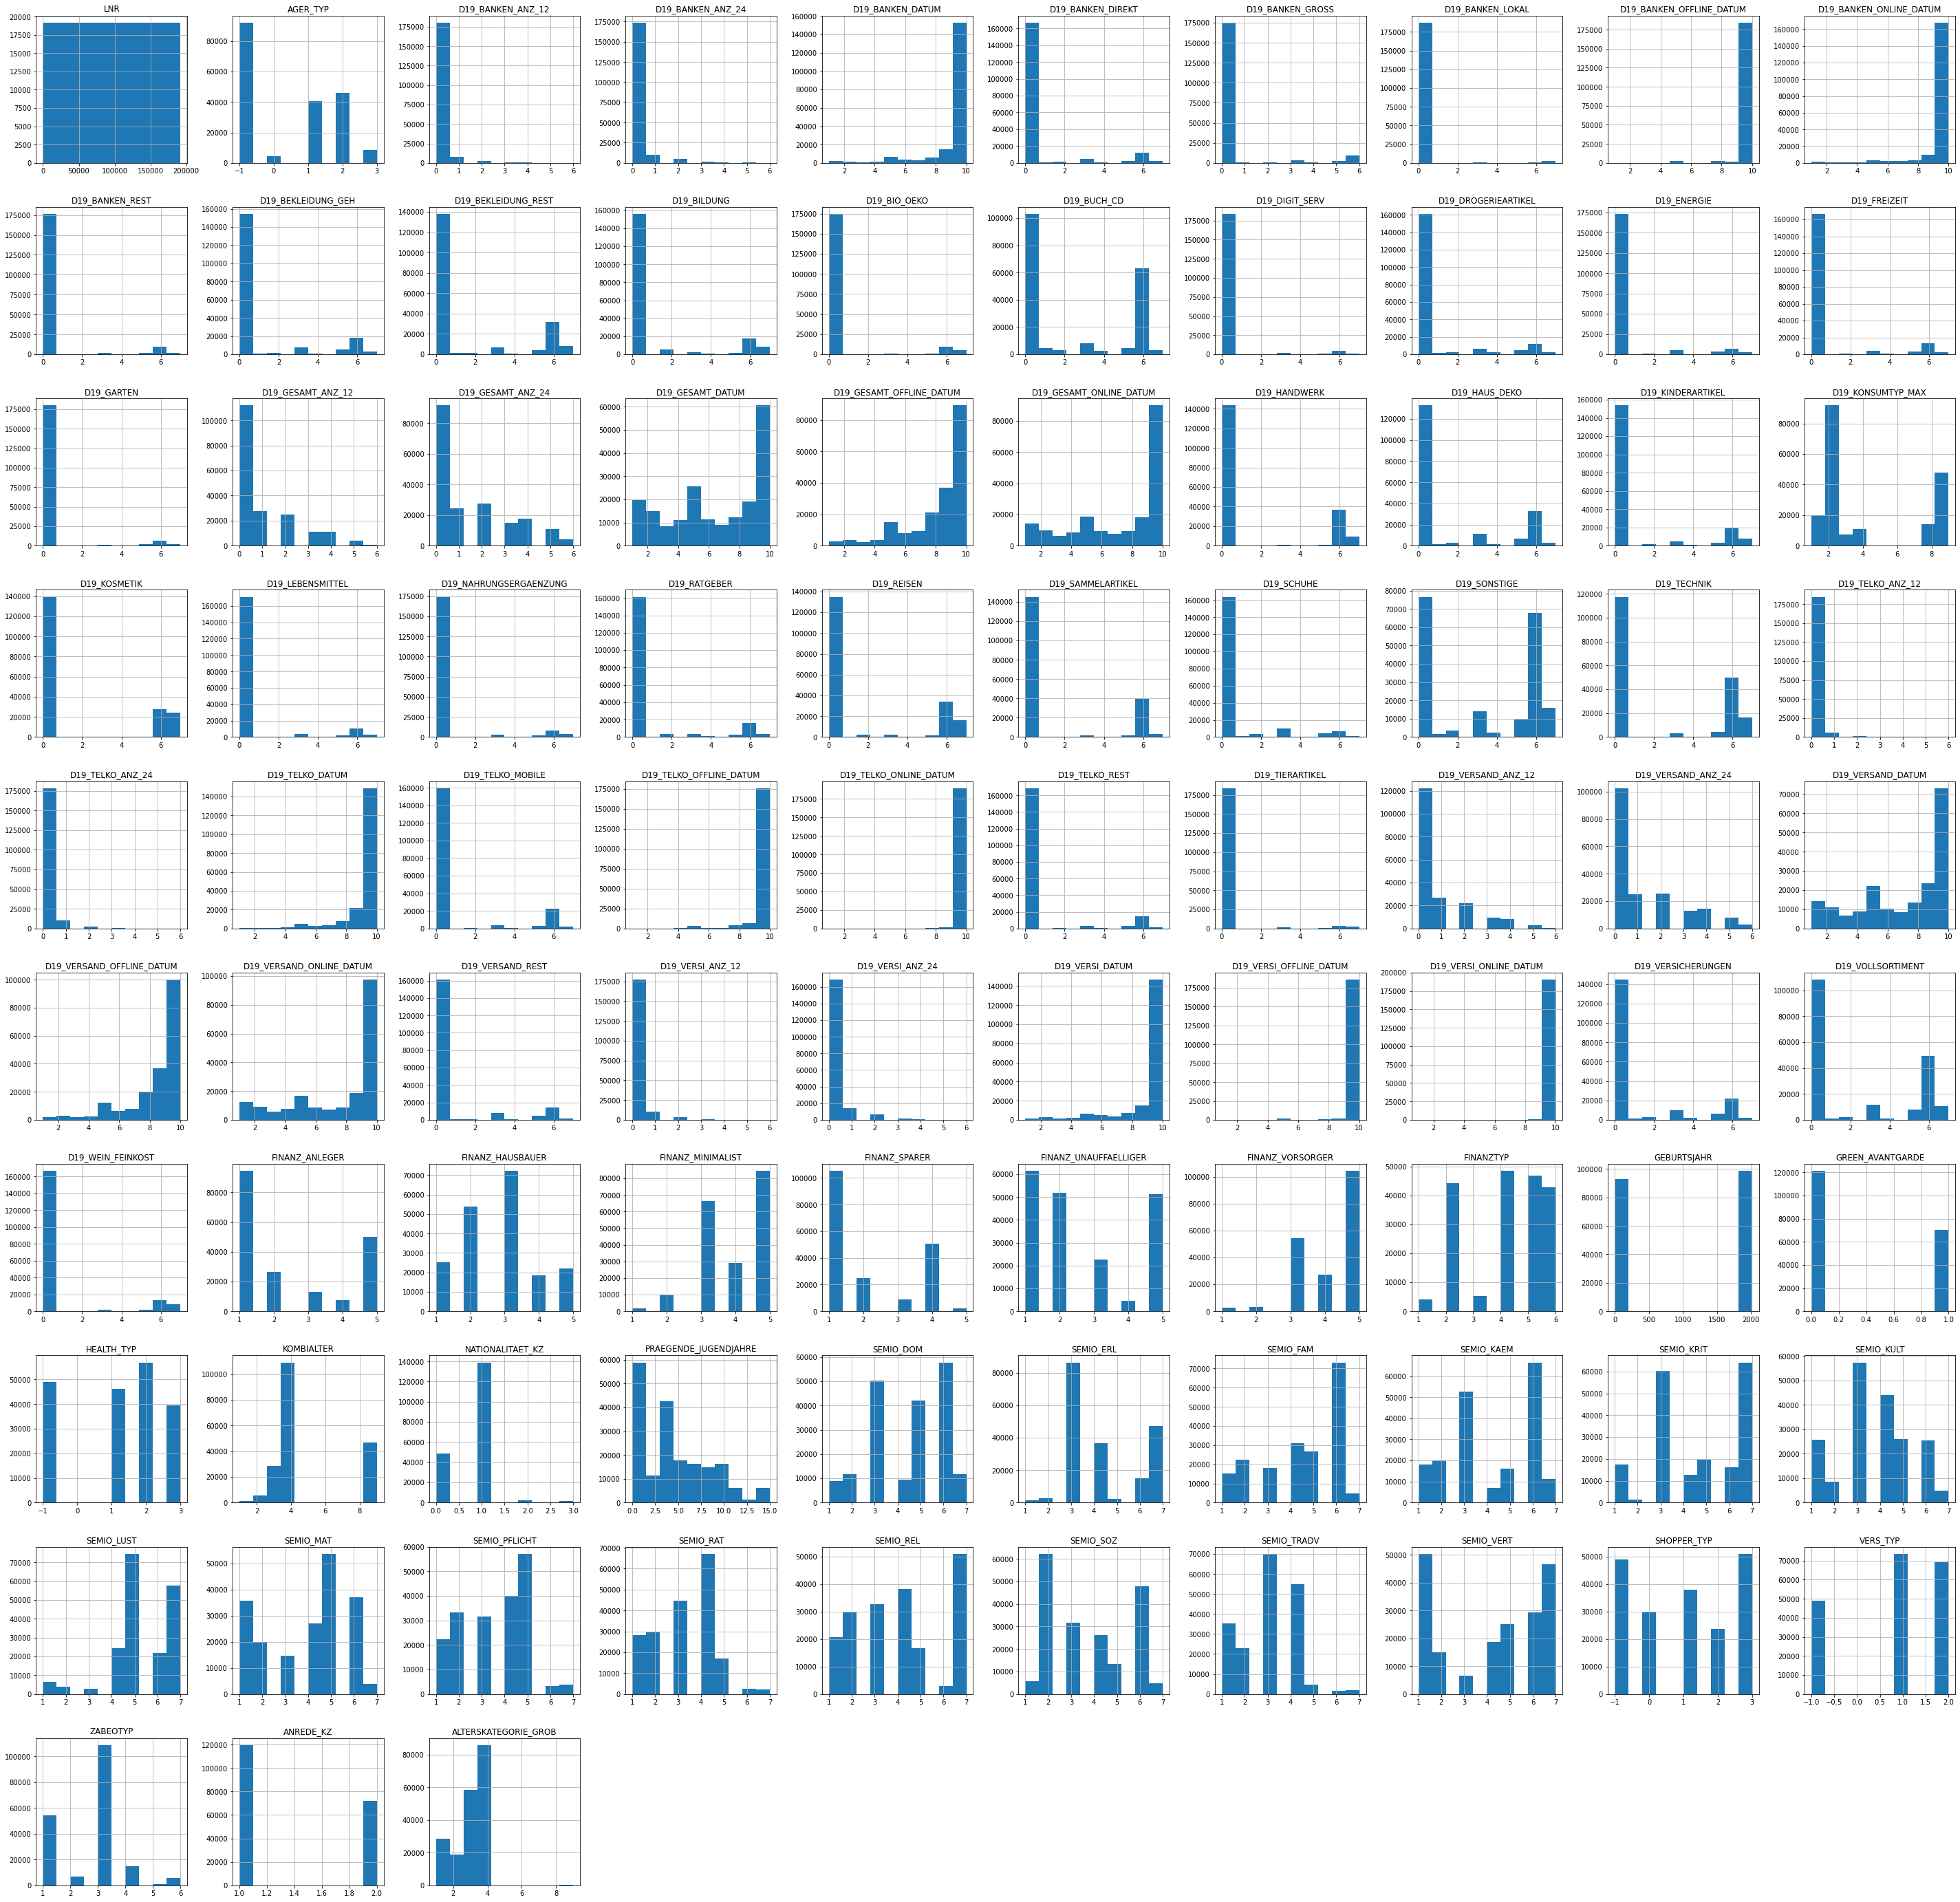

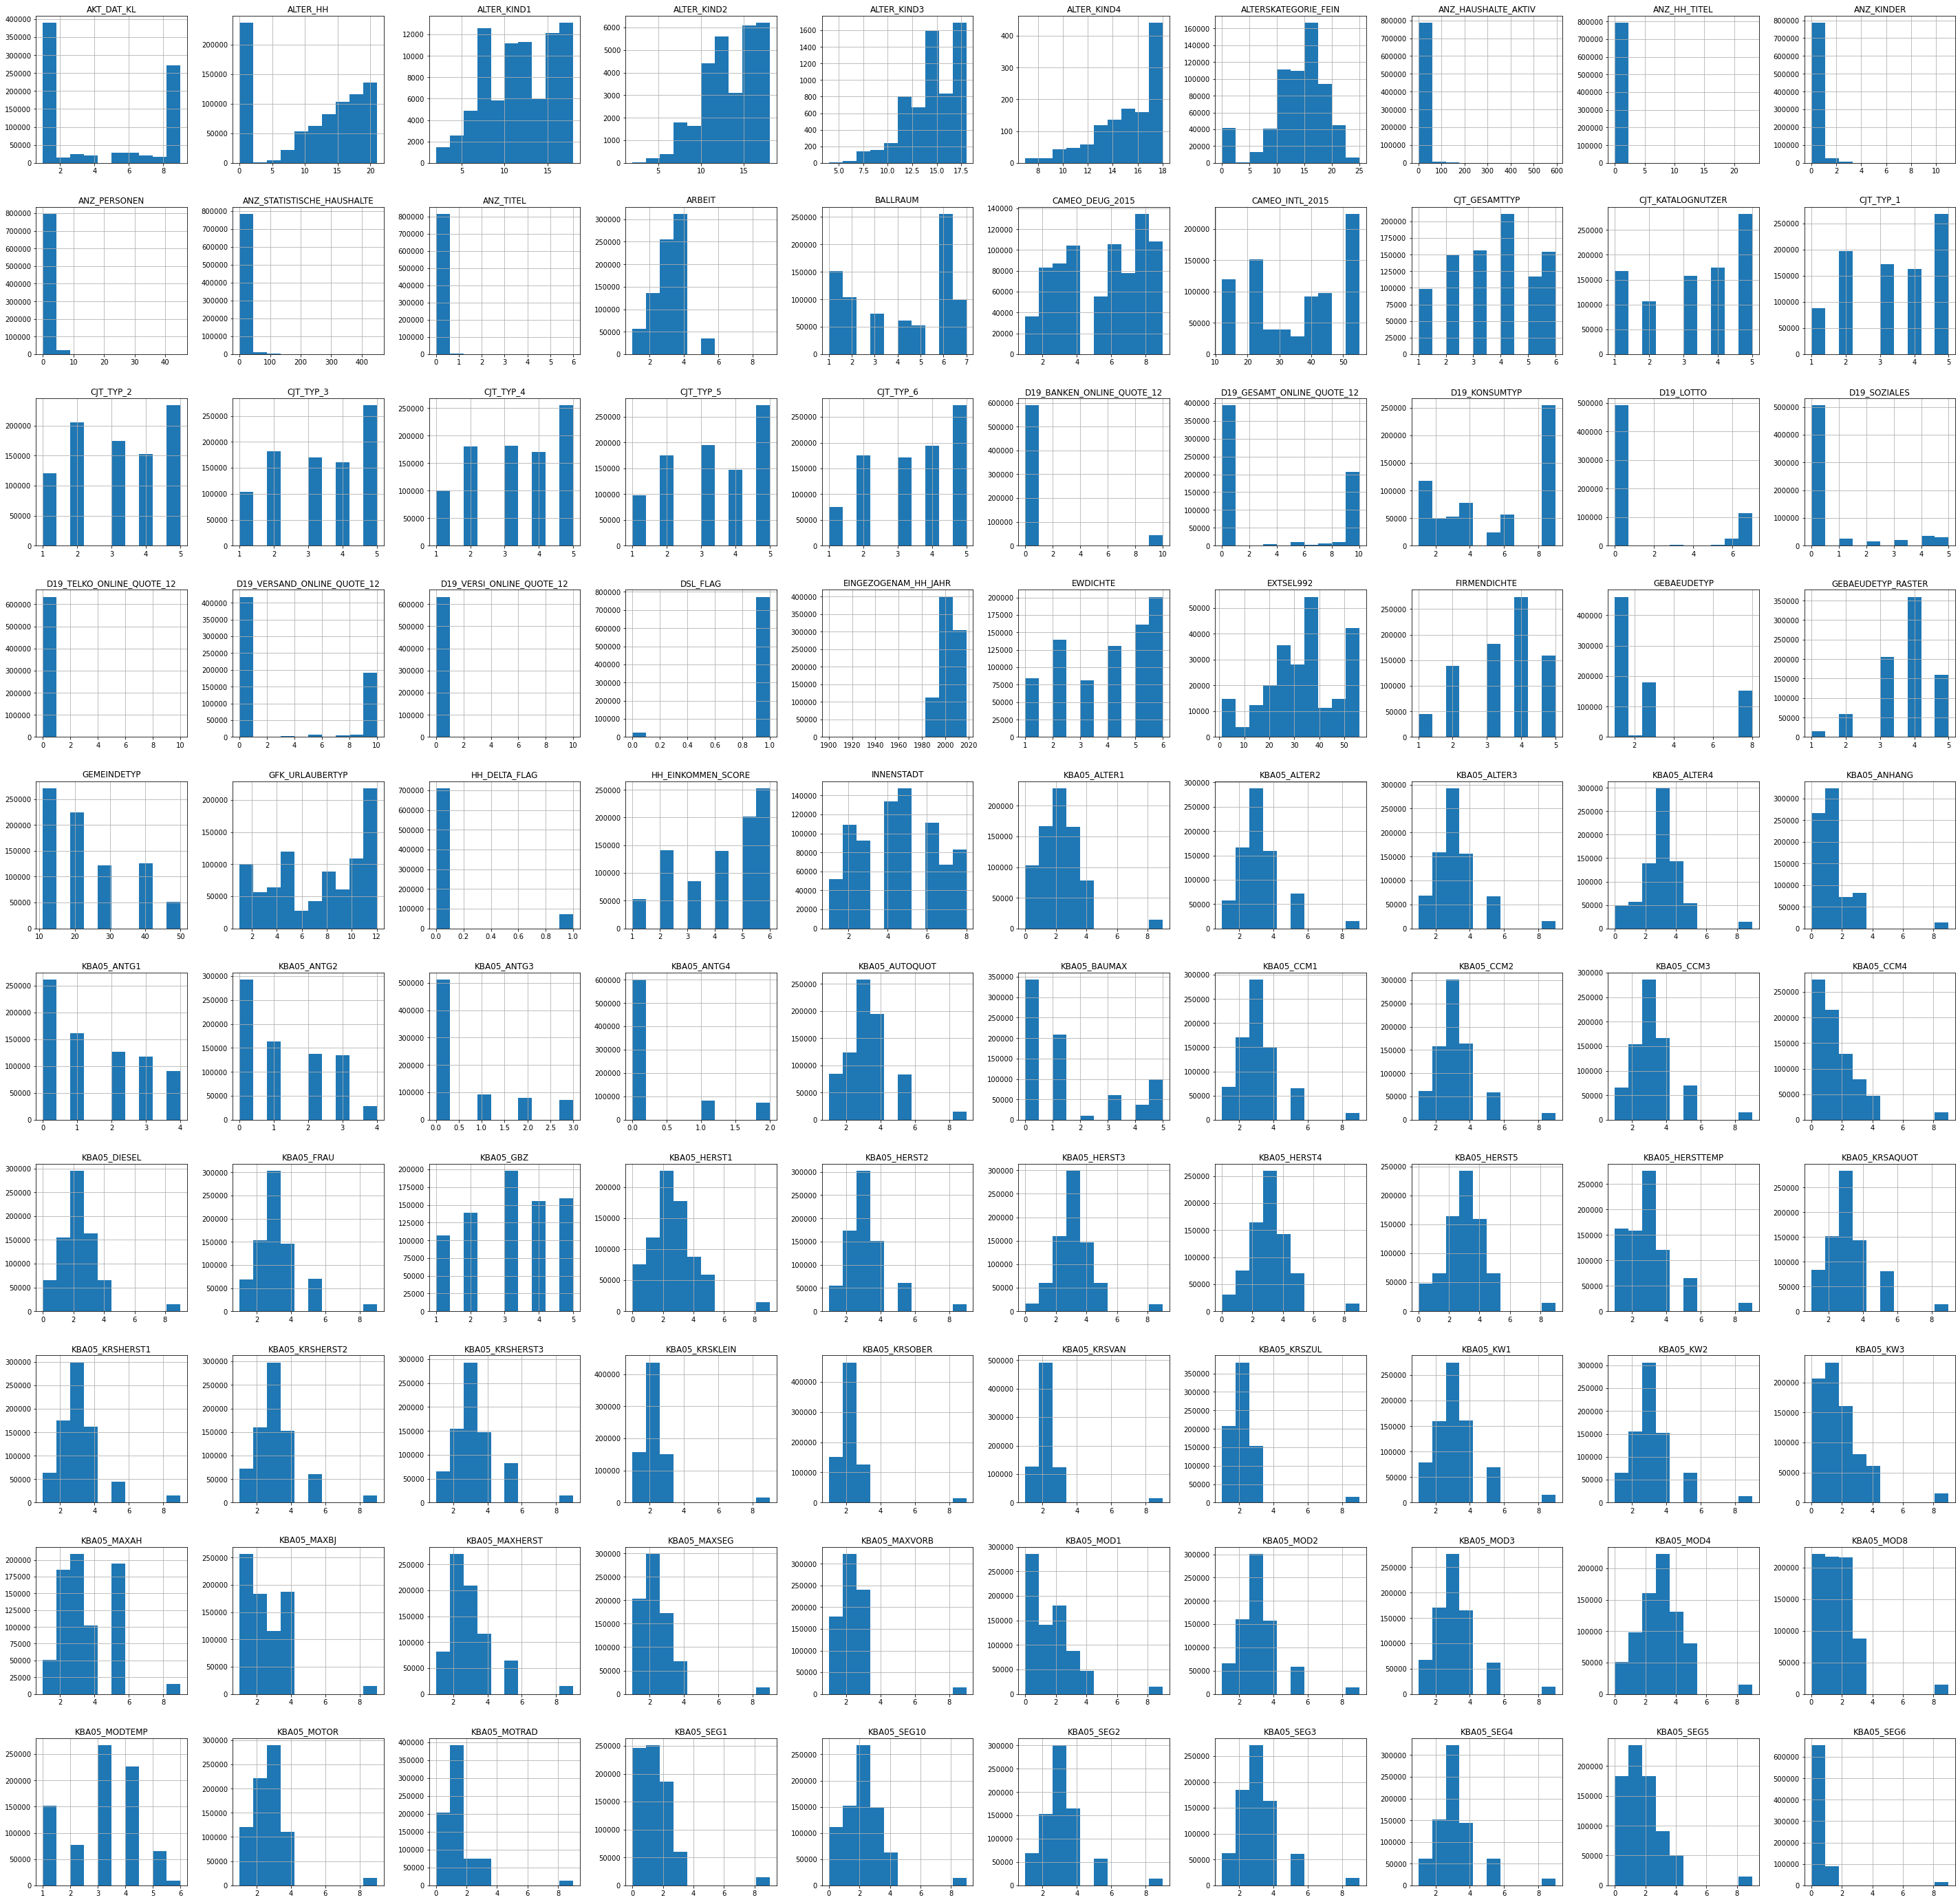

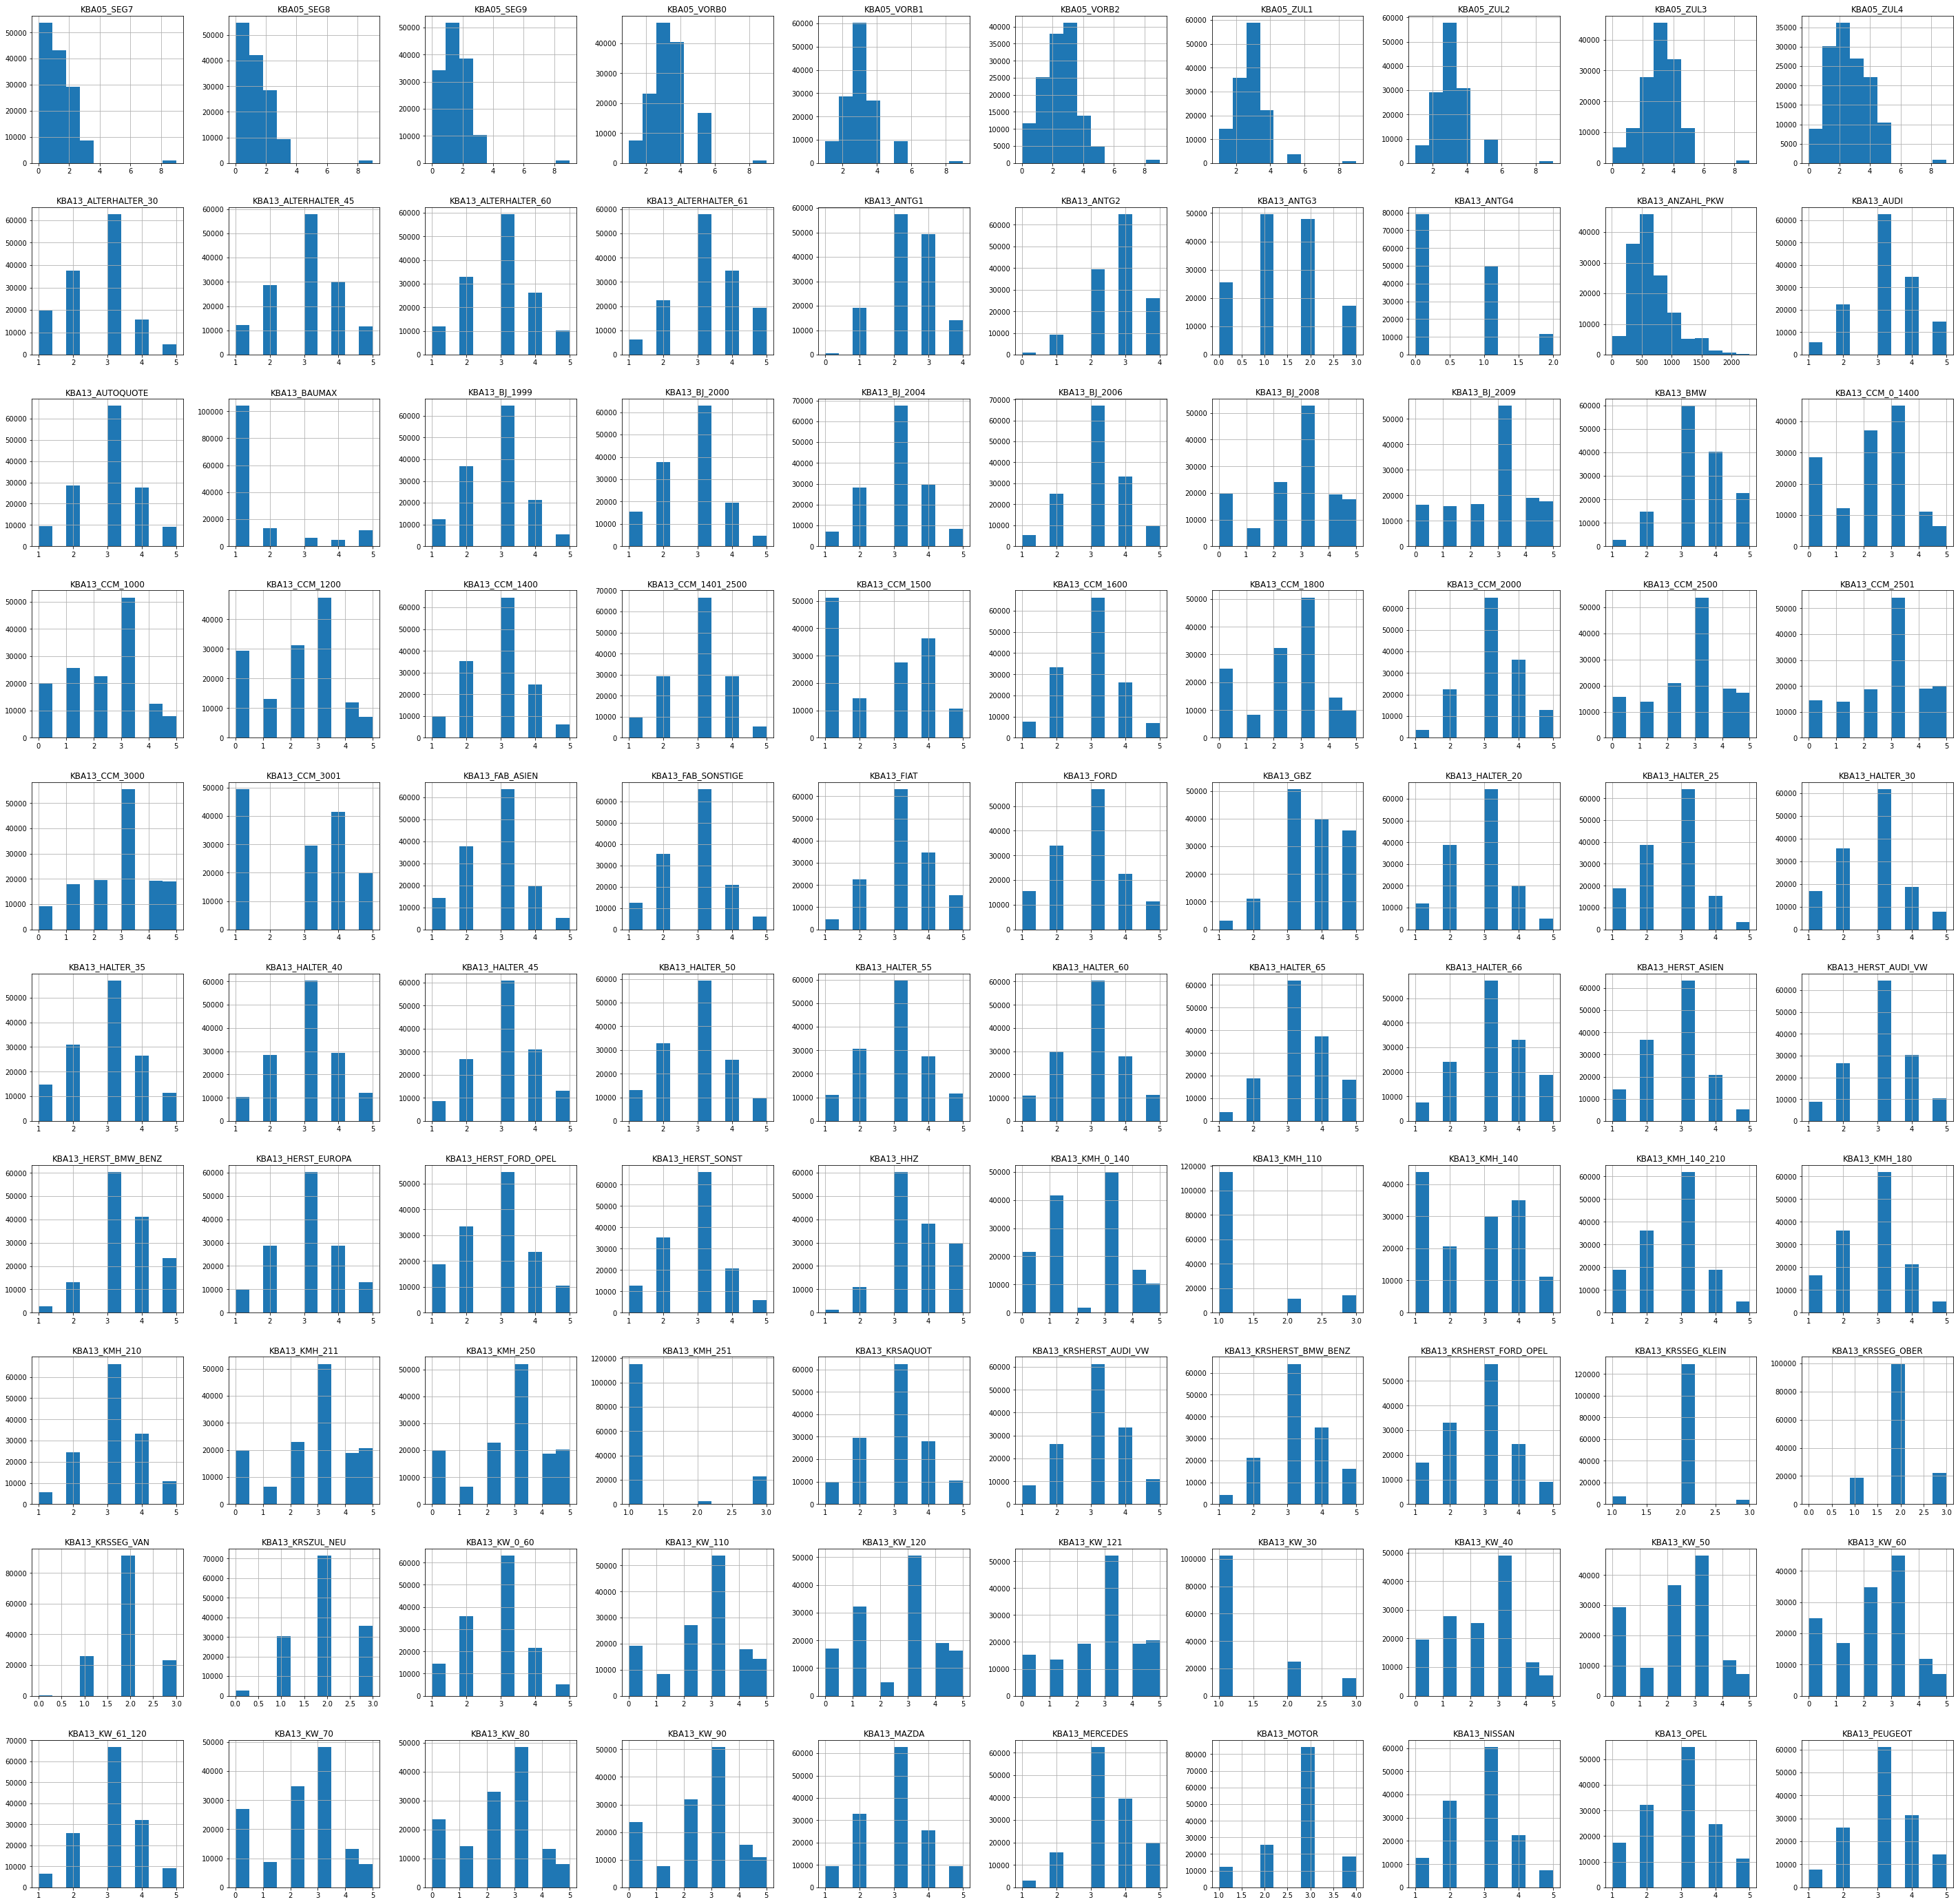

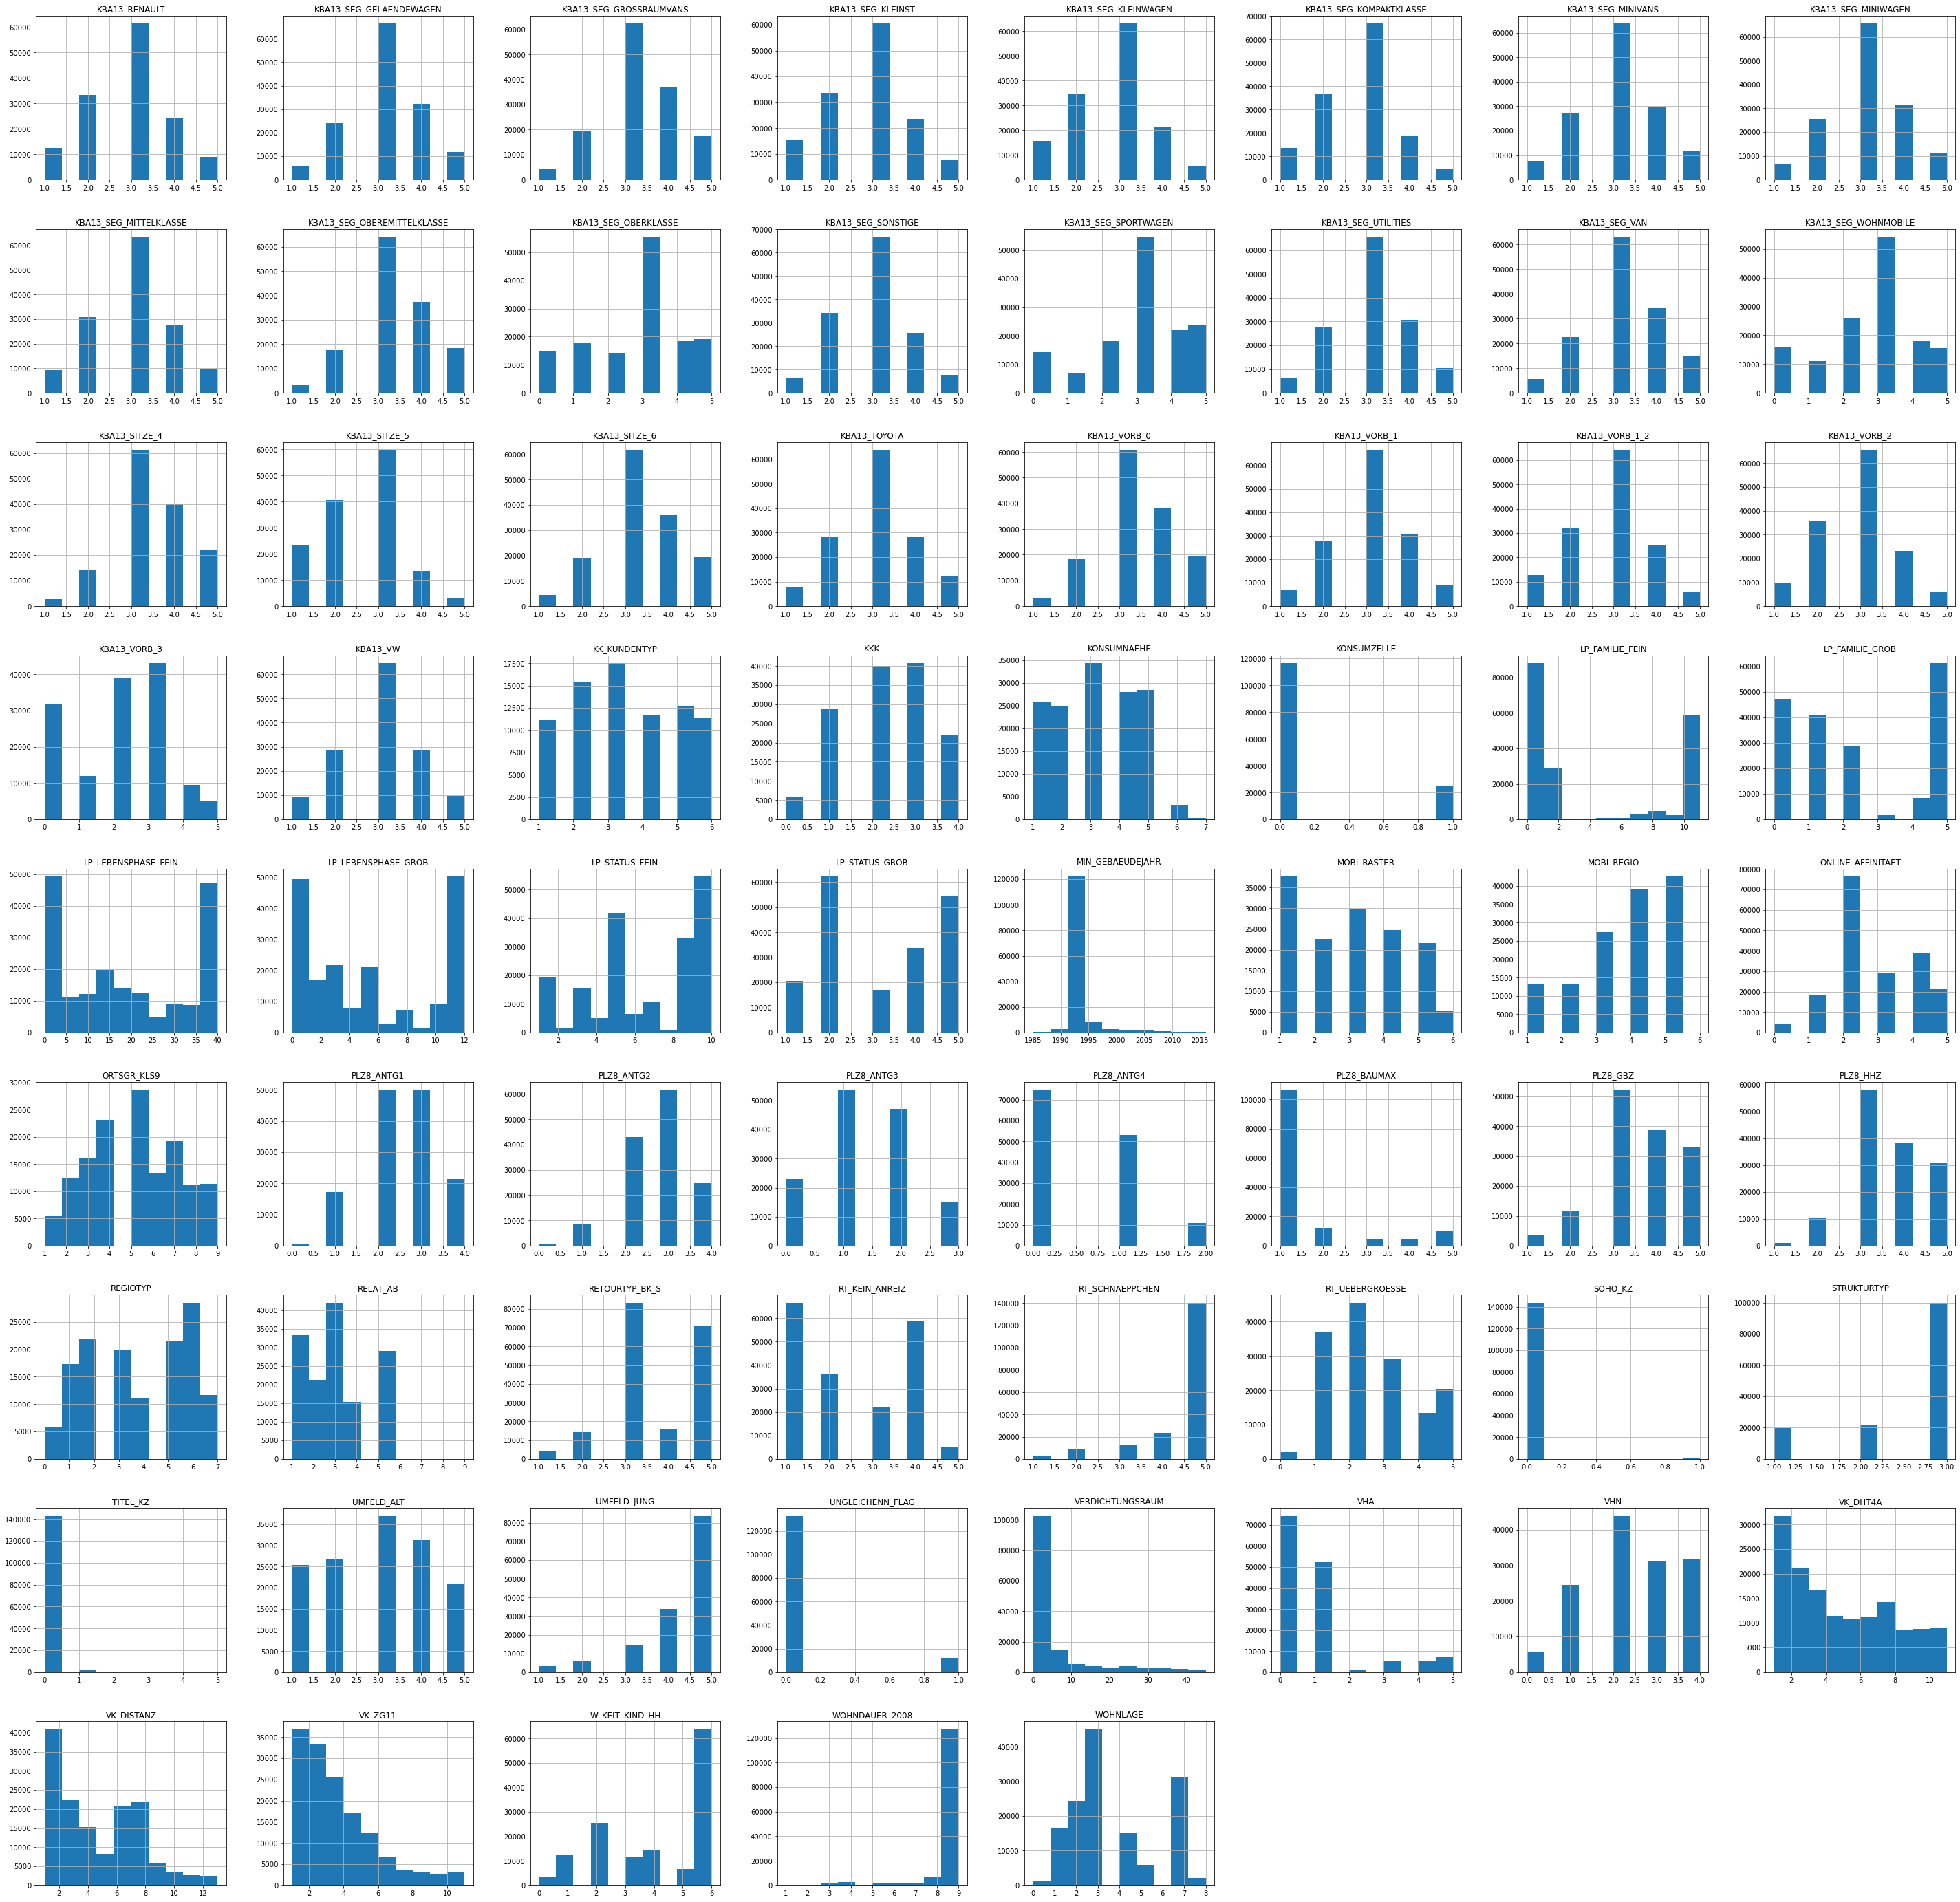

In [31]:
azdias, customers, df_dtypes = clean_dtypes(azdias, customers, df_dtypes)

In [32]:
# df_dtypes.value_counts()

In [34]:
def clean_unknown_invalid(azdias, customers, possible_values, unknown_values):
    '''
    Change unknown and invalied values in azdias and customers dataset to proper nan values
    
    INPUT:
         azdias: azdias DataFrame
         customers: customers DataFrame
         possible_values: Dictionary with possible values for each attribute
         unknown_values: Dictionary with unknown values for each attribute

    
    OUTPUT:
         azdias: azdias DataFrame with cleaned unknown and invalid values
         customers: customers DataFrame with cleaned unknown and invalid values
    
    '''

    print('.......... Remove Values that are not in the Possible Values List ..........')
    print('..... Check Numerical Attributes without Specific Ranges')
    #check if numerical attributes without specific range are valid
    for attr, val in possible_values.items():
     if 10000 in val:
          print(attr, azdias[attr].dtypes)

    for attr, val in possible_values.items():
     if 10000 not in val:
          azdias[attr] = azdias[attr].apply(lambda x: x if x in val else np.nan)
          customers[attr] = customers[attr].apply(lambda x: x if x in val else np.nan)
    
    print('.......... Remove Values that are Unknown ..........')
    for attr, val in unknown_values.items():
     azdias[attr] = azdias[attr].apply(lambda x: np.nan if x in val else x)
     customers[attr] = customers[attr].apply(lambda x: np.nan if x in val else x)
    
    print('.......... Cleaning Completed ..........')
    return azdias, customers



In [43]:
azdias_cl, customers_cl = clean_unknown_invalid(azdias, customers, possible_values, unknown_values)

.......... Remove Values that are not in the Possible Values List ..........
..... Check Numerical Attributes without Specific Ranges
MIN_GEBAEUDEJAHR float64
KBA13_ANZAHL_PKW float64
GEBURTSJAHR int64
.......... Remove Values that are Unknown ..........
.......... Cleaning Completed ..........


In [48]:
def plot_missing_values(azdias, customers):
    '''
    Plot missing values distribution
    
    INPUT:
         azdias: azdias DataFrame
         customers: customers DataFrame
          
    OUTPUT:
          Distribution of Missing Values for Azdias and Customers  
    '''

    plt.figure()

    sns.histplot(azdias.isnull().mean(), label='Azdias', bins=20, color='#66c2a5')
    sns.histplot(customers.isnull().mean(), label='Customers', bins=20, color='#ff7f0e')
    plt.ylabel('No. of Columns')
    plt.xlabel('Missing Values%')
    plt.title('Distribution of Missing Values for Azdias and Customers')
    plt.legend()
    plt.show()

In [49]:
def plot_missing_values_row(azdias, customers):
    '''
    Plot row-wise missing values distribution 
    
    INPUT:
         azdias: azdias DataFrame
         customers: customers DataFrame
          
    OUTPUT:
          Distribution of Missing Values for Azdias and Customers, Row-wise
    '''
    plt.figure()

    sns.histplot(azdias.isnull().sum(axis=1), label='Azdias', bins=20, color='#66c2a5')
    sns.histplot(customers.isnull().sum(axis=1), label='Customers', bins=20, color='#ff7f0e')
    plt.ylabel('No. of Rows')
    plt.xlabel('No. of Missing Values')
    plt.title('Distribution of Missing Values for Azdias and Customers, Row-wise')
    plt.legend()
    plt.show()

In [50]:
def clean_missing_values(azdias, customers, threshold_col=0.5, threshold_row=50):
    '''
    clean azdias and customers dataset by checking missing values
    
    INPUT:
         azdias: azdias DataFrame
         customers: customers DataFrame
         threshold_col: percentage to drop the column wise missing values
         threshold_row: number of rows to drop the row wise missing values

    
    OUTPUT:
         azdias: azdias DataFrame with acceptable percentage of missing values
         customers: customers DataFrame with acceptable percentage of missing values
    
    '''

    print('The Top 15 Columns with the Most Missing Values in Azdais: ')
    print('{}'.format(azdias.isnull().mean().sort_values(ascending=False)[0:15]))
    
    print('The Top 15 Columns with the Most Missing Values in Customers: ')
    print('{}'.format(customers.isnull().mean().sort_values(ascending=False)[0:15]))

    print('Column Wise Distribution:')
    plot_missing_values(azdias, customers)
    
    print('.......... Drop Columns with Missing Values Larger Than 50% ..........')
    # drop columns

    azdias_drop = set(azdias.columns[azdias.isnull().mean()>threshold_col])
    customers_drop = set(customers.columns[customers.isnull().mean()>threshold_col])
    drop_columns = azdias_drop.union(customers_drop)

    azdias = azdias.drop(drop_columns, axis=1)
    customers = customers.drop(drop_columns, axis=1)

    print('Column Wise Distribution after Dropping Missing Values:')
    plot_missing_values(azdias, customers)

    
    print('Row Wise Distribution:')
    plot_missing_values_row(azdias, customers)


    print('.......... Drop Rows with More Than 50 Missing Values ..........')
    azdias_temp = azdias.dropna(thresh=azdias.shape[1]-50)
    customers_temp = customers.dropna(thresh=customers.shape[1]-50)

    print('Azdias dataset removed {} rows'.format(azdias.shape[0]-azdias_temp.shape[0]))
    print('Customers dataset removed {} rows'.format(customers.shape[0]-customers_temp.shape[0]))

    print('Row Wise Distribution after Dropping Missing Values:')
    plot_missing_values_row(azdias_temp, customers_temp)

    # reset index
    azdias = azdias_temp.reset_index(drop=True)
    customers = customers_temp.reset_index(drop=True)

    
    print('.......... Cleaning Completed ..........')
    return azdias, customers



The Top 15 Columns with the Most Missing Values in Azdais: 
ALTER_KIND4             0.998648
TITEL_KZ                0.997576
ANZ_TITEL               0.996432
ALTER_KIND3             0.993077
ANZ_HH_TITEL            0.973251
ALTER_KIND2             0.966900
ALTER_KIND1             0.909048
AGER_TYP                0.760196
EXTSEL992               0.733996
KK_KUNDENTYP            0.655967
KBA05_BAUMAX            0.534687
ALTER_HH                0.348137
ANZ_HAUSHALTE_AKTIV     0.306781
ALTERSKATEGORIE_FEIN    0.295041
D19_SOZIALES            0.288495
dtype: float64
The Top 15 Columns with the Most Missing Values in Customers: 
ALTER_KIND4            0.998769
ALTER_KIND3            0.993347
TITEL_KZ               0.987936
ANZ_TITEL              0.985703
ALTER_KIND2            0.973389
ANZ_HH_TITEL           0.968798
ALTER_KIND1            0.938607
KK_KUNDENTYP           0.584064
KBA05_BAUMAX           0.571531
AGER_TYP               0.480595
EXTSEL992              0.444989
ANZ_PERSONEN   

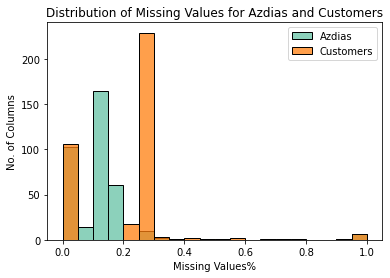

.......... Drop Columns with Missing Values Larger Than 50% ..........
Column Wise Distribution after Dropping Missing Values:


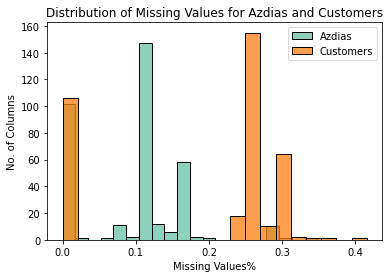

Row Wise Distribution:


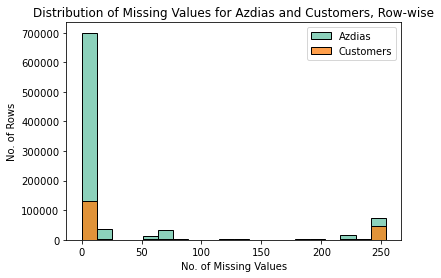

.......... Drop Rows with More Than 50 Missing Values ..........
Azdias dataset removed 153933 rows
Customers dataset removed 57406 rows
Row Wise Distribution after Dropping Missing Values:


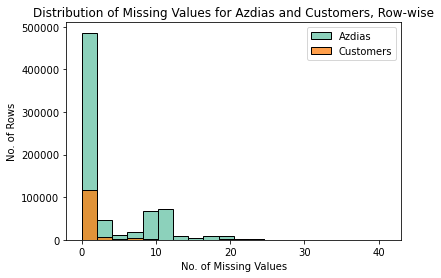

.......... Cleaning Completed ..........


In [51]:
azdias_copy, customers_copy = clean_missing_values(azdias_cl, customers_cl, threshold_col=0.5, threshold_row=50)

In [52]:
def save_cleaned_data(azdias, customers):
    '''
    Save cleaned azdias and customers data to csv files
    
    INPUT:
         azdias: azdias DataFrame
         customers: customers DataFrame
          
    OUTPUT:
          csv files for cleaned azdias and customers data
    '''
    azdias.to_csv('./data/azdias_cleaned.csv')
    customers.to_csv('./data/customers_cleaned.csv')